# LSTM for multivariable time-series classification

# Loading Data and transformations 

Here we apply tranpose to data 2D window. 

First we have data in [examples,variables,timesteps]

After apply transpose to every example we end up with : [examples,timesteps,variables] - ideal for LSTM


In [1]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.core import Activation, Lambda, Dropout 
from keras.models import Sequential
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Reshape
from keras.datasets import mnist
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam, Adadelta
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.layers.recurrent import LSTM
from keras.backend.tensorflow_backend import reshape
from keras.utils.vis_utils import plot_model
from keras.layers.merge import concatenate
from keras.legacy.layers import Merge, merge
from keras.layers.wrappers import Bidirectional, TimeDistributed
np.random.seed(1671)  # for reproducibility

sess = tf.Session()
K.set_session(sess)

class LSTMNet:
    @staticmethod
    def build(timeSteps,variables,classes):
        #CONV=>POOL
        inputNet = Input(shape=(timeSteps,variables)) #batch_shape=(20, 7, 5) 
        #lstm=Bidirectional(LSTM(100,recurrent_dropout=0.4,dropout=0.4),merge_mode='concat')(inputNet) #worse using stateful=True
        lstm=Bidirectional(LSTM(50),merge_mode='concat')(inputNet) #worse using stateful=True 
        #denselayers=Dense(400)(lstm)
        #denselayers=Activation("relu")(denselayers)
        #denselayers=Dropout(0.5)(denselayers)
        #denselayers=Dense(150)(denselayers)
        #denselayers=Activation("relu")(denselayers)
        #denselayers=Dropout(0.8)(denselayers)
        # a softmax classifier
        classificationLayer=Dense(classes,activation='softmax')(lstm)
        #classificationLayer=Activation("softmax")(classificationLayer)
        
        model=Model(inputNet,classificationLayer)
        return model



Using TensorFlow backend.
/home/rjpg/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('../NNNormalizeData-out.csv',header=None)  # 3 classes : up neutral down

np.random.seed(42) # always shuffle the same way 
df = df.reindex(np.random.permutation(df.index)) # shuffle examples 
df.reset_index(inplace=True, drop=True)

print(df)

inputs = []
target = []

y=0;    
for x in df.columns:
    if y != 35 :
        #print("added %d" %y)
        inputs.append(x)
    else :
        target.append(x)
    y+=1
print('***************************')

print(inputs)

total_inputs,total_output = df.as_matrix(inputs).astype(np.float32),df.as_matrix([target]).astype(np.int32)
print('###########################')
#print(total_inputs)
print(total_inputs.shape)

total_inputs = np.reshape(total_inputs, (-1,5,7))
print(total_inputs.shape)
print (type(total_inputs))
print(total_inputs[0])
#total= np.array([][][])
#total.append(total_inputs[0].T)
#total.append(total_inputs[1].T)
total=np.array([total_inputs[0].T])
for i in total_inputs:
    total=np.row_stack((total, [i.T]))
total=np.delete(total, 0, 0)
#total=np.row_stack((total, [total_inputs[2].T]))
#np.concatenate(total, total_inputs[1].T)
print(total.shape)
print (type(total))
print (total[0])

#total_inputs[0]=total_inputs[0].T
#print(total)
print('---------------------------')
#print(total_inputs)
#print(total_inputs.shape)

X_train=total#_inputs
y_train=total_output

#X_traiINPUT_SHAPEn, y_train , X_test, y_test
#X_train, X_test, y_train , y_test = train_test_split(total_inputs, total_output, test_size=0.15, random_state=42)

#-------------- End Load Data -----------


             0         1         2         3         4         5         6   \
0     -0.723996  0.141094 -1.000000  0.625387  0.083214 -0.336045 -0.111275   
1     -0.242433 -0.087491 -0.292871  0.674107  0.240492  0.330299  1.000000   
2      0.514309 -0.801817 -0.881654 -0.560150  0.040320  0.078849  0.208871   
3     -0.036048 -0.573233  0.452922  0.414264  0.297684  0.041131  0.036484   
4      1.000000 -0.830390 -0.567637 -0.998636 -0.445811 -0.248037 -0.234408   
5      0.101541  0.598263  1.000000  1.000000  0.540749  1.000000 -0.887013   
6     -0.036048 -0.773244  1.000000 -0.625111 -1.000000  0.066276 -0.308288   
7     -0.999174 -0.144637  0.237034 -1.000000 -1.000000 -1.000000 -0.529927   
8      1.000000  0.055375 -0.037731  0.284342  0.512153 -0.864091 -0.074335   
9      0.032746  0.026802  0.923949  0.235621 -0.174149 -0.688076 -0.037395   
10    -0.380022  0.912566 -0.292871 -1.000000 -0.460109  0.430879  0.171931   
11    -0.036048  1.000000  1.000000  0.186901  0.054

In [3]:



NB_EPOCH = 200
# network and training
BATCH_SIZE = 20
VERBOSE = 1
OPTIMIZER = Adam()
VALIDATION_SPLIT=0.2

IMG_ROWS, IMG_COLS = 7, 5 # input image dimensions
NB_CLASSES = 5  # number of outputs = number of classes
INPUT_SHAPE = (1, IMG_ROWS, IMG_COLS)


K.set_image_dim_ordering("th")

# consider them as float and normalize
#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')
print("-------------- [0 , 1] ----------------------")
X_train += 1 
X_train /= 2
print(X_train)
#X_test += 1  

print(X_train.shape[0], 'train samples')
#print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, NB_CLASSES)
#y_test = np_utils.to_categorical(y_test, NB_CLASSES)

# initialize the optimizer and model
model = LSTMNet.build(timeSteps=7,variables=5,classes=5)

model.summary()
model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,
    metrics=["accuracy"])


# Prepare saver.
#builder = tf.saved_model.builder.SavedModelBuilder("./model_keras")

# Initialize all variables
sess.run(tf.global_variables_initializer())


tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
esCallBack = EarlyStopping(monitor='val_acc', min_delta=0, patience=12, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)


-------------- [0 , 1] ----------------------
[[[ 0.13800219  0.7494837   0.44616941  1.          0.88619292]
  [ 0.57054687  0.60991865  0.07995555  0.86528474  0.34631324]
  [ 0.          0.43845138  0.51078618  0.51077223  0.81673896]
  ..., 
  [ 0.54160708  0.40343556  0.31298512  1.          0.58409458]
  [ 0.33197761  0.42442995  0.07949686  0.          0.08880219]
  [ 0.44436234  0.95387381  0.37175381  0.75231272  0.        ]]

 [[ 0.3787837   1.          0.          0.          0.59141368]
  [ 0.45625463  0.          0.34722742  0.22690132  0.94139904]
  [ 0.35356459  0.13750389  0.41564047  1.          0.33489498]
  ..., 
  [ 0.62024593  0.87661493  0.49192688  0.6586619   0.        ]
  [ 0.66514957  0.44399163  0.          0.70816708  0.36096665]
  [ 1.          0.3327558   1.          0.61178285  0.88297468]]

 [[ 0.75715464  0.64266896  0.96925032  1.          0.74291277]
  [ 0.09909138  0.33399653  0.65108675  0.36530301  0.        ]
  [ 0.05917275  0.50640726  0.43277681

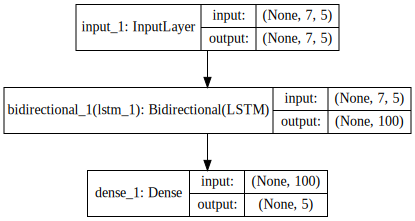

In [4]:
from IPython.display import SVG,display
from keras.utils.vis_utils import model_to_dot
modelSVG=SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
display(modelSVG)


In [5]:
history = model.fit(X_train, y_train, 
        batch_size=BATCH_SIZE, epochs=NB_EPOCH, 
        verbose=2, # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
        validation_split=VALIDATION_SPLIT, callbacks=[tbCallBack,reduce_lr,esCallBack])

Train on 15564 samples, validate on 3892 samples
Epoch 1/200
11s - loss: 1.5935 - acc: 0.2474 - val_loss: 1.5914 - val_acc: 0.2513
Epoch 2/200
13s - loss: 1.5882 - acc: 0.2481 - val_loss: 1.5908 - val_acc: 0.2554
Epoch 3/200
16s - loss: 1.5861 - acc: 0.2557 - val_loss: 1.5845 - val_acc: 0.2636
Epoch 4/200
17s - loss: 1.5843 - acc: 0.2585 - val_loss: 1.5843 - val_acc: 0.2623
Epoch 5/200
14s - loss: 1.5802 - acc: 0.2679 - val_loss: 1.5847 - val_acc: 0.2672
Epoch 6/200
18s - loss: 1.5761 - acc: 0.2682 - val_loss: 1.5778 - val_acc: 0.2718
Epoch 7/200
16s - loss: 1.5708 - acc: 0.2783 - val_loss: 1.5710 - val_acc: 0.2711
Epoch 8/200
17s - loss: 1.5627 - acc: 0.2860 - val_loss: 1.5639 - val_acc: 0.2783
Epoch 9/200
16s - loss: 1.5529 - acc: 0.2952 - val_loss: 1.5645 - val_acc: 0.2785
Epoch 10/200
18s - loss: 1.5423 - acc: 0.3012 - val_loss: 1.5537 - val_acc: 0.2919
Epoch 11/200
17s - loss: 1.5300 - acc: 0.3088 - val_loss: 1.5510 - val_acc: 0.2927
Epoch 12/200
16s - loss: 1.5171 - acc: 0.3178 -

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


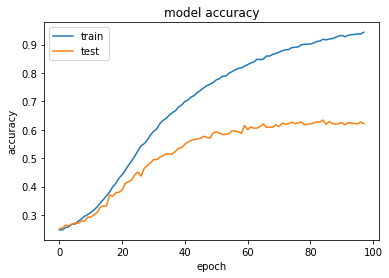

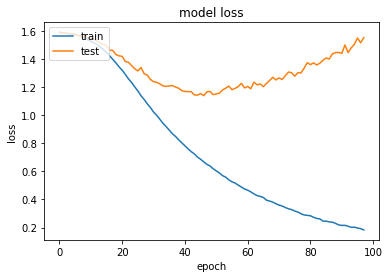

In [7]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()